<a href="https://colab.research.google.com/github/sarvasvaKhare/ROM_cylinder/blob/main/ROM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nwL_cGrCPdVO15G10vfr7DznMHOZiEIw' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nwL_cGrCPdVO15G10vfr7DznMHOZiEIw" -O ParaView-v5.9.1.tar.gz && rm -rf /tmp/cookies.txt
!sudo mv ParaView-v5.9.1.tar.gz /opt/
%cd /opt
!sudo tar xf ParaView-v5.9.1.tar.gz
!sudo rm ParaView-v5.9.1.tar.gz
%cd ParaView-5.9.1-MPI-Linux-Python3.8-64bit
import sys
sys.path.insert(0, "/opt/ParaView-5.9.1-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages")
!wget https://cloud.tu-braunschweig.de/s/sJYEfzFG7yDg3QT/download/datasets_13_09_2022.tar.gz
!tar xzf datasets_13_09_2022.tar.gz
!sudo rm datasets_13_09_2022.tar.gz

--2023-02-18 09:10:13--  https://docs.google.com/uc?export=download&confirm=t&id=1nwL_cGrCPdVO15G10vfr7DznMHOZiEIw
Resolving docs.google.com (docs.google.com)... 172.253.114.100, 172.253.114.102, 172.253.114.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.114.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b35nvdal2pc89mbgh7g1d9n7at52ruql/1676711400000/11687854275746841412/*/1nwL_cGrCPdVO15G10vfr7DznMHOZiEIw?e=download&uuid=a2816a37-e7c5-4070-acfa-097609021493 [following]
--2023-02-18 09:10:13--  https://doc-0s-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b35nvdal2pc89mbgh7g1d9n7at52ruql/1676711400000/11687854275746841412/*/1nwL_cGrCPdVO15G10vfr7DznMHOZiEIw?e=download&uuid=a2816a37-e7c5-4070-acfa-097609021493
Resolving doc-0s-5g-docs.googleusercontent.com (doc-0s-5g-docs.googleusercontent.com)... 172.217.219.

In [ ]:
from typing import Tuple, Dict
from itertools import groupby
from collections import defaultdict
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
!pip3 install git+https://github.com/FlowModelingControl/flowtorch
import flowtorch
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# make results reproducible
pt.manual_seed(0)

# create output directory
output = "output"
!mkdir -p $output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/FlowModelingControl/flowtorch to /tmp/pip-req-build-el9ogfur
  Running command git clone --filter=blob:none --quiet https://github.com/FlowModelingControl/flowtorch /tmp/pip-req-build-el9ogfur
  Resolved https://github.com/FlowModelingControl/flowtorch to commit 4cc377cc54c06f5c03d4f01bcdb485282e5e2b9e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 119.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 KB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
def create_normal_cluster(center: Tuple[float], stdev: Tuple[float],
                          n_points: int) -> pt.Tensor:
    """Create cluster of normally distributed points.
    """
    assert len(center) == len(stdev)
    n_dim = len(center)
    cluster = pt.zeros((n_points, n_dim))
    for i, (mean, std) in enumerate(zip(center, stdev)):
        cluster[:, i] = pt.normal(mean, std, size=(n_points,))
    return cluster

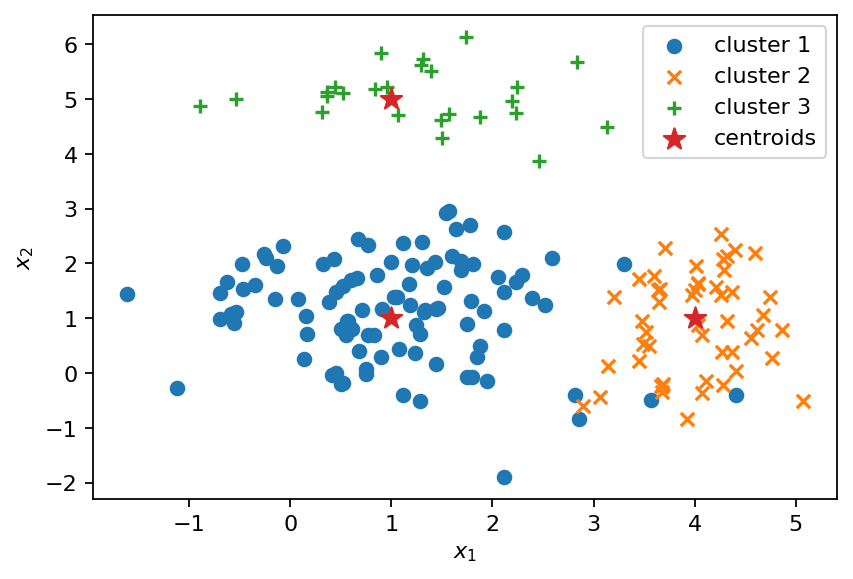

In [ ]:
cluster_1 = create_normal_cluster((1.0, 1.0), (1.0, 1.0), 100)
cluster_2 = create_normal_cluster((4.0, 1.0), (0.5, 1.0), 50)
cluster_3 = create_normal_cluster((1.0, 5.0), (1.0, 0.5), 25)
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], marker="o", label="cluster 1")
plt.scatter(cluster_2[:, 0], cluster_2[:, 1], marker="x", label="cluster 2")
plt.scatter(cluster_3[:, 0], cluster_3[:, 1], marker="+", label="cluster 3")
plt.scatter((1.0, 4.0, 1.0), (1.0, 1.0, 5.0), marker="*", c="C3", s=100, label="centroids")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/clustering_test_data.svg", bbox_inches="tight")

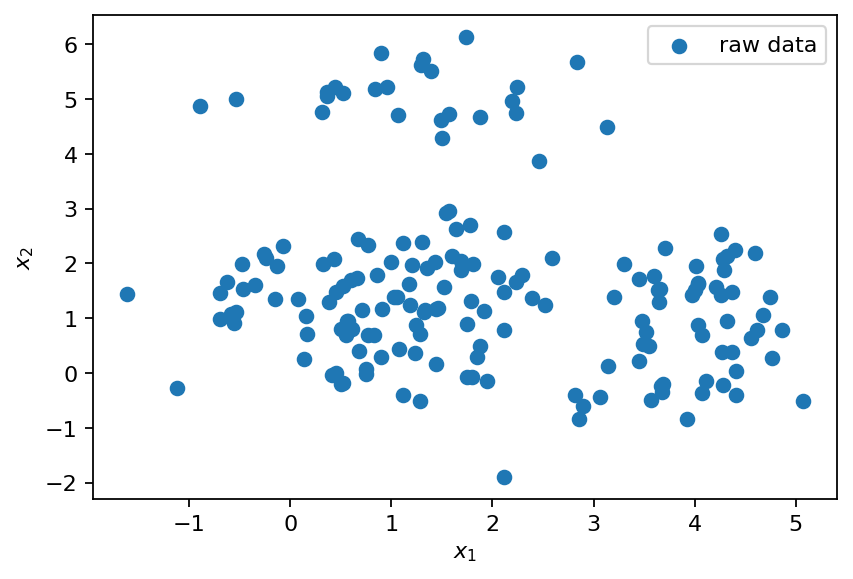

In [ ]:
data = pt.cat((cluster_1, cluster_2, cluster_3))
rows_shuffled = pt.randperm(data.shape[0])
data = data[rows_shuffled]

plt.scatter(data[:, 0], data[:, 1], marker="o", label="raw data")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/clustering_test_data_no_labels.svg", bbox_inches="tight")

In [ ]:
def initialize_centroids_randomly(k: int, data: pt.Tensor) -> pt.Tensor:
    """Randomly select data points as initial centroids.
    """
    n_points = data.shape[0]
    probs = pt.ones(n_points) / n_points
    rows = pt.multinomial(probs, k)
    return data[rows]

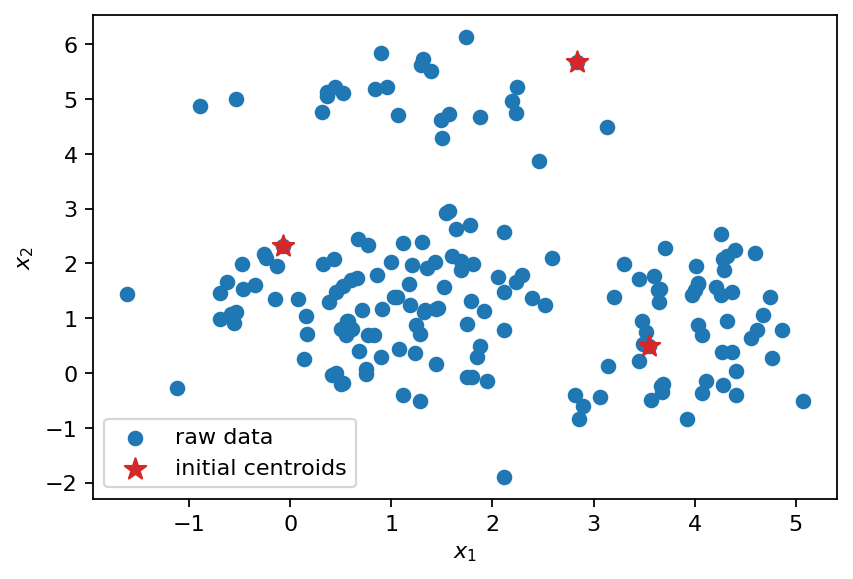

In [ ]:
centroids = initialize_centroids_randomly(3, data)

plt.scatter(data[:, 0], data[:, 1], marker="o", label="raw data")
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", c="C3", s=100, label="initial centroids")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/random_initial_centroids.svg", bbox_inches="tight")

In [ ]:
def find_nearest_centroid(centroids: pt.Tensor, data: pt.Tensor) -> pt.Tensor:
    """Find the id of the nearest centroid for each data point.
    """
    n_points = data.shape[0]
    n_centroids = centroids.shape[0]
    labels = pt.zeros(n_points, dtype=pt.int64)
    distance = pt.zeros((n_points, n_centroids))
    for i in range(n_centroids):
        distance[:, i] = pt.linalg.norm(data - centroids[i], dim=1)
    return pt.argmin(distance, dim=1)

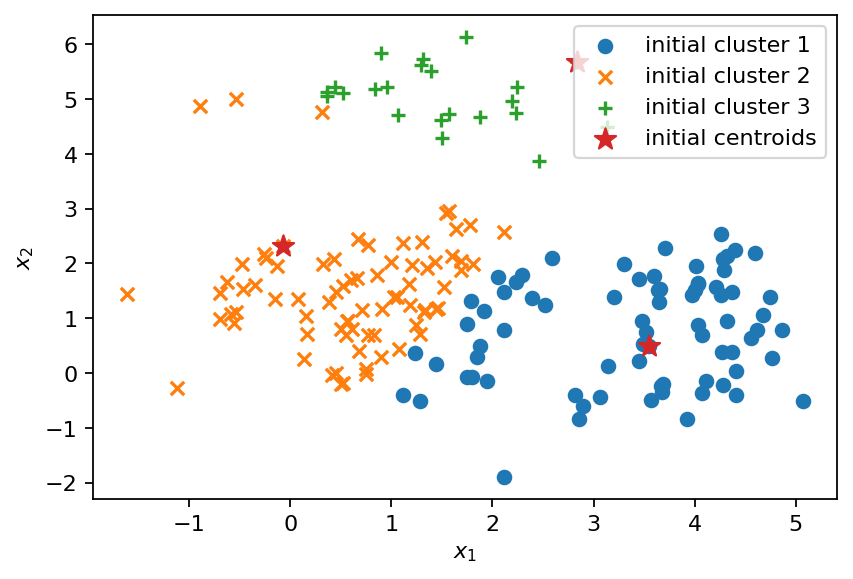

In [ ]:
initial_labels = find_nearest_centroid(centroids, data)
cl_1 = data[initial_labels == 0]
cl_2 = data[initial_labels == 1]
cl_3 = data[initial_labels == 2]
plt.scatter(cl_1[:, 0], cl_1[:, 1], marker="o", label="initial cluster 1")
plt.scatter(cl_2[:, 0], cl_2[:, 1], marker="x", label="initial cluster 2")
plt.scatter(cl_3[:, 0], cl_3[:, 1], marker="+", label="initial cluster 3")
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", c="C3", s=100, label="initial centroids")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/intial_cluster_labels.svg", bbox_inches="tight")

In [ ]:
def update_centroids(centroids: pt.Tensor, data: pt.Tensor) -> pt.Tensor:
    """Update centroid position based on cluster mean value.
    """
    n_centroids = centroids.shape[0]
    new_centroids = pt.zeros_like(centroids)
    cluster_ids = find_nearest_centroid(centroids, data)
    for i in range(n_centroids):
        new_centroids[i] = data[cluster_ids == i].mean(dim=0)
    return new_centroids

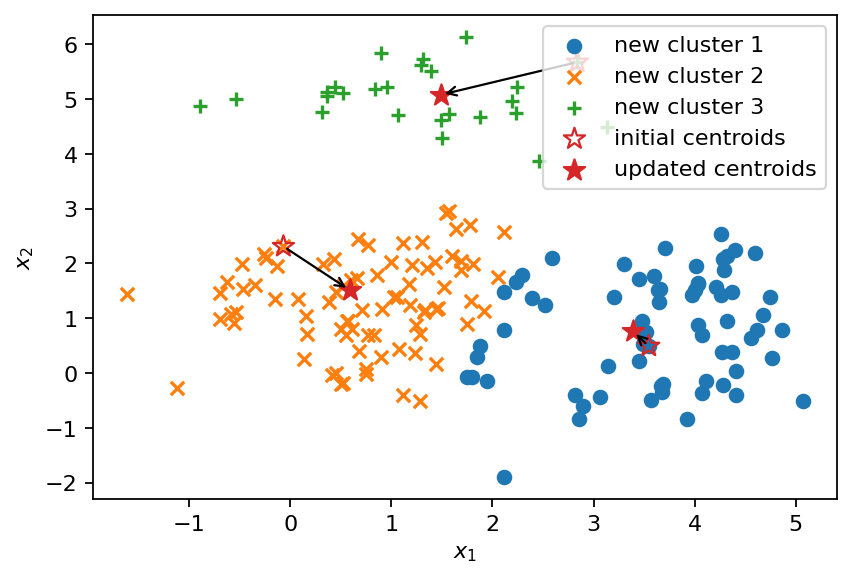

In [ ]:
new_centroids = update_centroids(centroids, data)
new_labels = find_nearest_centroid(new_centroids, data)
cl_1 = data[new_labels == 0]
cl_2 = data[new_labels == 1]
cl_3 = data[new_labels == 2]
plt.scatter(cl_1[:, 0], cl_1[:, 1], marker="o", label="new cluster 1")
plt.scatter(cl_2[:, 0], cl_2[:, 1], marker="x", label="new cluster 2")
plt.scatter(cl_3[:, 0], cl_3[:, 1], marker="+", label="new cluster 3")
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", edgecolors="C3", s=100, facecolors="none", label="initial centroids")
plt.scatter(new_centroids[:, 0], new_centroids[:, 1], marker="*", c="C3", s=100, label="updated centroids")
for i in range(centroids.shape[0]):
    plt.annotate("", xy=new_centroids[i], xytext=centroids[i], arrowprops=dict(arrowstyle="->"))
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/updated_cluster_labels.svg", bbox_inches="tight")

In [ ]:
max_iter = 10
tol = 1.0e-4

centroids_hist = []
centroids_hist.append(initialize_centroids_randomly(3, data))
for it in range(max_iter):
    centroids_hist.append(update_centroids(centroids_hist[-1], data))
    mean_diff = pt.linalg.norm(centroids_hist[-1]-centroids_hist[-2], dim=1).mean()
    if mean_diff < tol:
        print(f"Clustering converged after {it+1} iterations.")
        break

Clustering converged after 6 iterations.


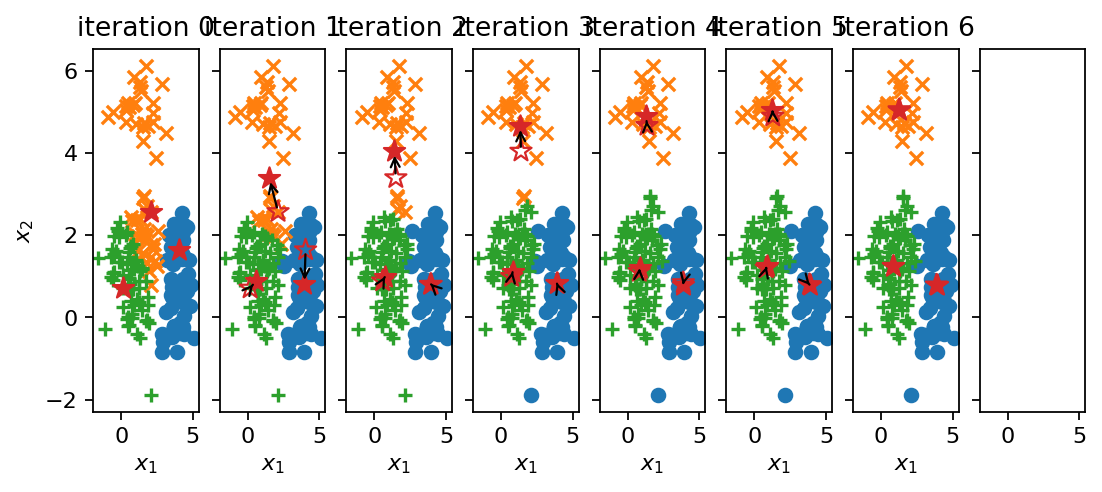

In [ ]:
fig, axarr = plt.subplots(1, 8, figsize=(8, 3), sharex=True, sharey=True)
for i, ct in enumerate(centroids_hist[:7]):
    labels = find_nearest_centroid(centroids_hist[i], data)
    cl_1 = data[labels == 0]
    cl_2 = data[labels == 1]
    cl_3 = data[labels == 2]
    axarr[i].scatter(cl_1[:, 0], cl_1[:, 1], marker="o")
    axarr[i].scatter(cl_2[:, 0], cl_2[:, 1], marker="x")
    axarr[i].scatter(cl_3[:, 0], cl_3[:, 1], marker="+")
    axarr[i].scatter(ct[:, 0], ct[:, 1], marker="*", c="C3", s=100)
    if i > 0:
        axarr[i].scatter(centroids_hist[i-1][:, 0], centroids_hist[i-1][:, 1], marker="*", edgecolors="C3", facecolors="none", s=100)
        for j in range(centroids_hist[-1].shape[0]):
            axarr[i].annotate("", xy=centroids_hist[i][j], xytext=centroids_hist[i-1][j], arrowprops=dict(arrowstyle="->"))
    axarr[i].set_xlabel(r"$x_1$")
    axarr[i].set_title(f"iteration {i}")
axarr[0].set_ylabel(r"$x_2$")

plt.savefig(f"{output}/kmeans_iterations.svg", bbox_inches="tight")

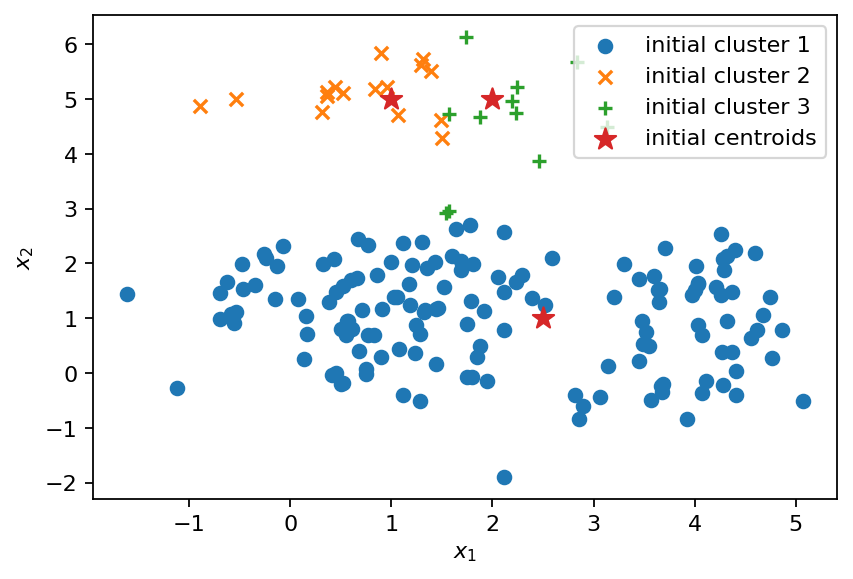

In [ ]:
bad_centroids = pt.tensor([[2.5, 1.0], [1.0, 5.0], [2.0, 5.0]])
initial_labels = find_nearest_centroid(bad_centroids, data)
cl_1 = data[initial_labels == 0]
cl_2 = data[initial_labels == 1]
cl_3 = data[initial_labels == 2]
plt.scatter(cl_1[:, 0], cl_1[:, 1], marker="o", label="initial cluster 1")
plt.scatter(cl_2[:, 0], cl_2[:, 1], marker="x", label="initial cluster 2")
plt.scatter(cl_3[:, 0], cl_3[:, 1], marker="+", label="initial cluster 3")
plt.scatter(bad_centroids[:, 0], bad_centroids[:, 1], marker="*", c="C3", s=100, label="initial centroids")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/bad_intial_centroids.svg", bbox_inches="tight")

In [ ]:
max_iter = 10
tol = 1.0e-4

bad_centroids_hist = []
bad_centroids_hist.append(bad_centroids)
for it in range(max_iter):
    bad_centroids_hist.append(update_centroids(bad_centroids_hist[-1], data))
    mean_diff = pt.linalg.norm(bad_centroids_hist[-1]-bad_centroids_hist[-2], dim=1).mean()
    if mean_diff < tol:
        print(f"Clustering converged after {it+1} iterations.")
        break

Clustering converged after 3 iterations.


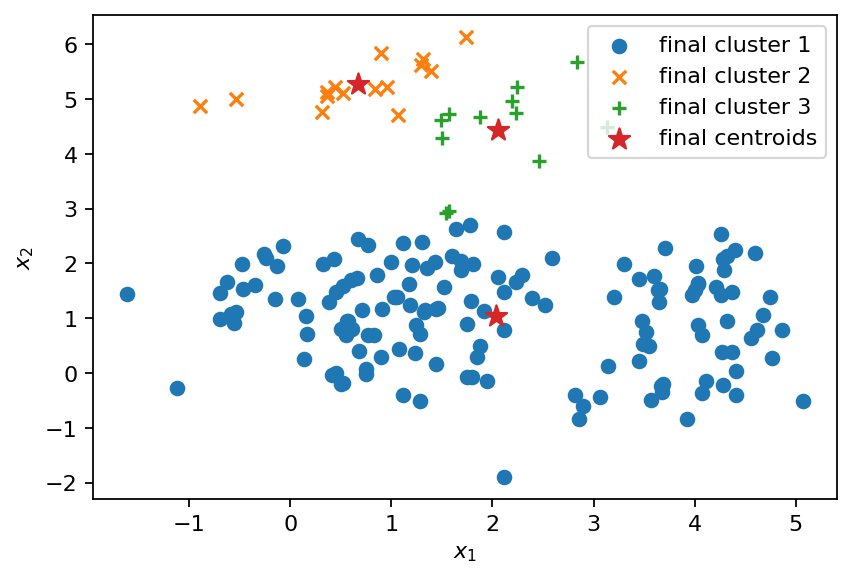

In [ ]:
final_labels = find_nearest_centroid(bad_centroids_hist[-1], data)
cl_1 = data[final_labels == 0]
cl_2 = data[final_labels == 1]
cl_3 = data[final_labels == 2]
plt.scatter(cl_1[:, 0], cl_1[:, 1], marker="o", label="final cluster 1")
plt.scatter(cl_2[:, 0], cl_2[:, 1], marker="x", label="final cluster 2")
plt.scatter(cl_3[:, 0], cl_3[:, 1], marker="+", label="final cluster 3")
plt.scatter(bad_centroids_hist[-1][:, 0], bad_centroids_hist[-1][:, 1], marker="*", c="C3", s=100, label="final centroids")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/bad_intial_centroids_final.svg", bbox_inches="tight")

In [ ]:
def compute_cluster_inertia(centroids: pt.Tensor, data: pt.Tensor) -> float:
    """Compute sum of squared distances over all clusters.
    """
    labels = find_nearest_centroid(centroids, data)
    inertia = 0.0
    for i in range(data.shape[1]):
        inertia += pt.linalg.norm(data[labels==i]-centroids[i], dim=1).square().sum()
    return inertia
print("Inertia for random initialization: {:2.4f}".format(compute_cluster_inertia(centroids_hist[-1], data)))
print("Inertia for bad initialization: {:2.4f}".format(compute_cluster_inertia(bad_centroids_hist[-1], data)))

Inertia for random initialization: 110.1418
Inertia for bad initialization: 540.7017


In [ ]:
def initialize_centroids_improved(k: int, data: pt.Tensor) -> pt.Tensor:
    """Randomly select data points as initial centroids.
    """
    n_points = data.shape[0]
    probs = pt.ones(n_points) / n_points
    rows = pt.zeros(k, dtype=pt.int64)
    rows[0] = pt.multinomial(probs, 1)
    distance = pt.zeros((n_points, k-1))
    for i in range(1, k):
        distance[:, i-1] = pt.linalg.norm(data-data[rows[i-1]], dim=1).square()
        min_dist = distance[:, :i].min(dim=1).values
        probs = min_dist / min_dist.sum()
        rows[i] = pt.multinomial(probs, 1)
    return data[rows]

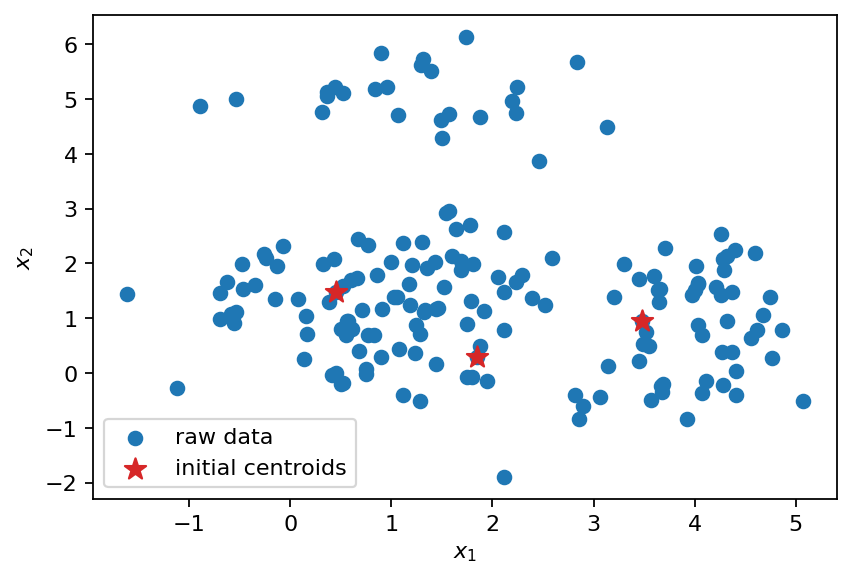

In [ ]:
centroids = initialize_centroids_improved(3, data)

plt.scatter(data[:, 0], data[:, 1], marker="o", label="raw data")
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", c="C3", s=100, label="initial centroids")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/improved_initial_centroids.svg", bbox_inches="tight")

In [ ]:
initialization_methods = {
    "random" : initialize_centroids_randomly,
    "kmeans++" : initialize_centroids_improved
}

def find_centroids(k: int, data: pt.Tensor, max_iter: int=100,
                   tol: float=1.0e-6, init: str="random", verbose=False) -> Tuple[pt.Tensor, int]:
    centroids = initialization_methods[init](k, data)
    for i in range(max_iter):
        old_centroids = centroids[:]
        centroids = update_centroids(centroids, data)
        mean_diff = pt.linalg.norm(centroids-old_centroids, dim=1).mean()
        if mean_diff < tol:
            if verbose:
                print(f"Clustering converged after {i+1} iterations.")
            break
    return centroids, i+1

In [ ]:
repeat = 100
inertia_random, inertia_improved = [], []
iter_random, iter_improved = [], []

for _ in range(repeat):
    centroids, it = find_centroids(3, data, init="random")
    inertia_random.append(compute_cluster_inertia(centroids, data).item())
    iter_random.append(it)
    centroids, it = find_centroids(3, data, init="kmeans++")
    inertia_improved.append(compute_cluster_inertia(centroids, data).item())
    iter_improved.append(it)

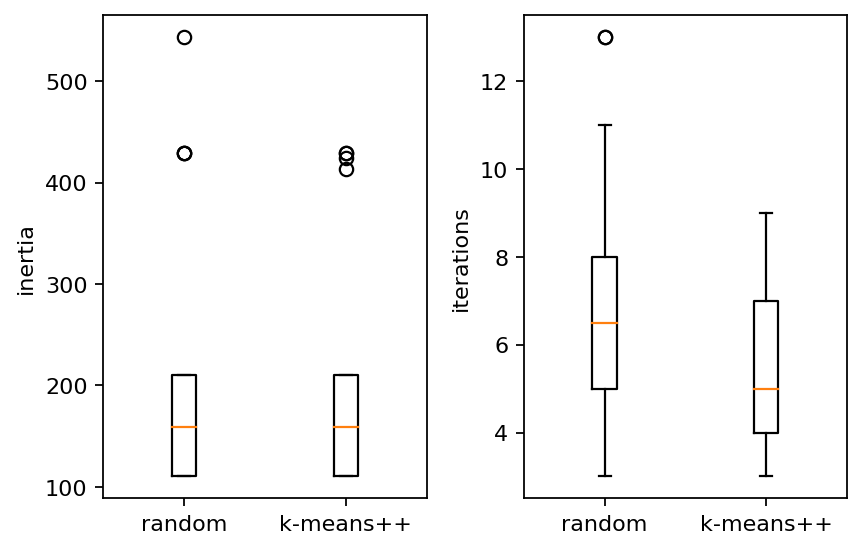

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot((inertia_random, inertia_improved), labels=("random", "k-means++"))
ax2.boxplot((iter_random, iter_improved), labels=("random", "k-means++"))
ax1.set_ylabel("inertia")
ax2.set_ylabel("iterations")
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{output}/random_vs_improved.svg", bbox_inches="tight")

In [ ]:
t = pt.linspace(0.0, 2.0*np.pi, 100)
data = pt.zeros((100, 2))
data[:, 0] = pt.sin(t) + pt.normal(0.0, 0.05, (100,))
data[:, 1] = pt.cos(t) + pt.normal(0.0, 0.05, (100,))

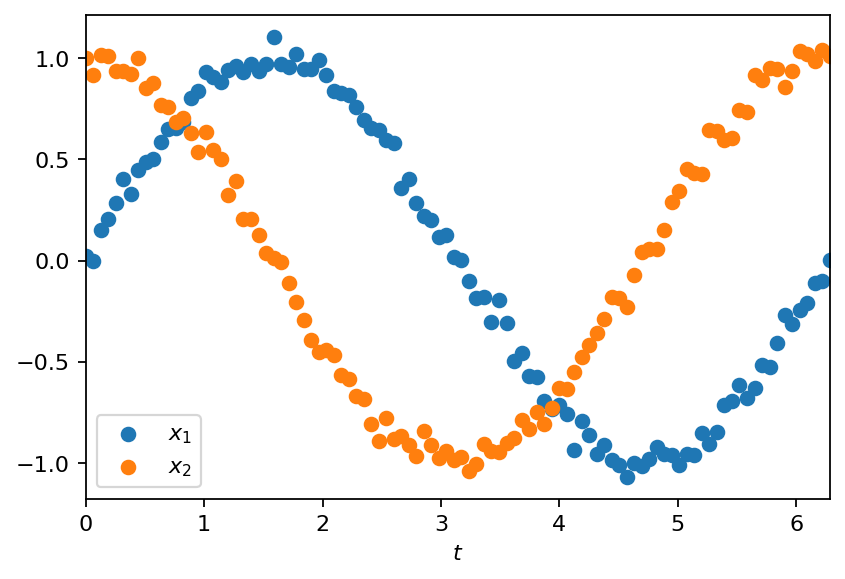

In [ ]:
plt.scatter(t, data[:, 0], label=r"$x_1$")
plt.scatter(t, data[:, 1], label=r"$x_2$")
plt.xlabel(r"$t$")
plt.legend()
plt.xlim(0.0, 2.0*np.pi)
plt.savefig(f"{output}/periodic_dataset_raw_time.svg", bbox_inches="tight")

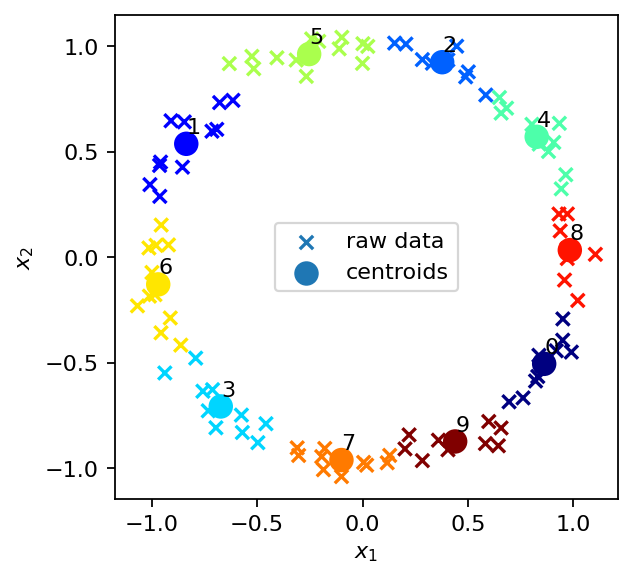

In [ ]:
clustering = KMeans(n_clusters=10, random_state=2)
clustering.fit(data.numpy())
cluster_ids = clustering.predict(data.numpy())
centroids = clustering.cluster_centers_

plt.scatter(data[:, 0], data[:, 1], c=cluster_ids, marker="x", cmap="jet", label="raw data")
plt.scatter(centroids[:, 0], centroids[:, 1], c=range(10), marker="o", s=100, cmap="jet", label="centroids")
for i, c in enumerate(centroids):
    plt.text(c[0], c[1]+0.05, f"{i}")
plt.gca().set_aspect("equal")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/periodic_dataset_clustering.svg", bbox_inches="tight")

In [ ]:
def remove_sequential_duplicates(sequence: np.ndarray) -> np.ndarray:
    """Get sequence of integers without sequential duplicates.
    """
    is_different = np.diff(sequence).astype(bool)
    return sequence[np.insert(is_different, 0, True)]

def compute_transition_time(cluster_sequence: np.ndarray,
                            dt: float, verbose=False) -> Dict[str, float]:
    """Compute transition time between cluster centroids.
    """
    if verbose:
        print("sequence: ", cluster_sequence)
    centroid_sequence = remove_sequential_duplicates(cluster_sequence)
    if verbose:
        print("centroid sequence: ", centroid_sequence)
    seq_duplicates = np.array(
            [sum(1 for _ in group)
             for _, group in groupby(cluster_sequence)]
    )
    if verbose:
        print("sequential duplicates: ", seq_duplicates)
    transition = defaultdict(list)
    for i in range(len(centroid_sequence)-1):
        key = ",".join(map(str, centroid_sequence[i:i+2]))
        transition[key].append(
            0.5 * dt *
            np.sum(seq_duplicates[i:i+2])
        )
    return {key: np.mean(value) for key, value in transition.items()}

In [ ]:
transition_times = compute_transition_time(cluster_ids, 2.0*np.pi/100, True)

sequence:  [5 5 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 8 8 8 8 8 8 8 8 0 0 0 0 0 0 0 0
 0 9 9 9 9 9 9 9 9 9 7 7 7 7 7 7 7 7 7 7 3 3 3 3 3 3 3 3 3 3 6 6 6 6 6 6 6
 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5]
centroid sequence:  [5 2 4 8 0 9 7 3 6 1 5]
sequential duplicates:  [ 2  9 10  8  9  9 10 10 11 11 11]


In [ ]:
transition_times

{'5,2': 0.3455751918948773,
 '2,4': 0.5969026041820608,
 '4,8': 0.5654866776461628,
 '8,0': 0.5340707511102649,
 '0,9': 0.5654866776461628,
 '9,7': 0.5969026041820608,
 '7,3': 0.6283185307179586,
 '3,6': 0.6597344572538566,
 '6,1': 0.6911503837897546,
 '1,5': 0.6911503837897546}

In [ ]:
def get_next_cluster(current: int, transitions: list) -> int:
    for t in transitions:
        if t.startswith(str(current)):
            return int(t[-1:])

In [ ]:
def simulate(centroids: np.ndarray, transition_times: Dict[str, float],
             start_id: int, end_time) -> Tuple[np.ndarray, np.ndarray]:
    visited_centroids, time = [start_id], [0.0]
    while time[-1] < end_time:
        visited_centroids.append(get_next_cluster(visited_centroids[-1], transition_times.keys()))
        transition = "{:d},{:d}".format(*visited_centroids[-2:])
        time.append(time[-1] + transition_times[transition])
        if time[-1] > end_time:
            break
    visited = np.zeros((len(time), centroids.shape[1]))
    for i, ci in enumerate(visited_centroids):
        visited[i] = centroids[ci]
    return visited, np.array(time)


In [ ]:
prediction, times = simulate(centroids, transition_times, clustering.labels_[0], 4*np.pi)

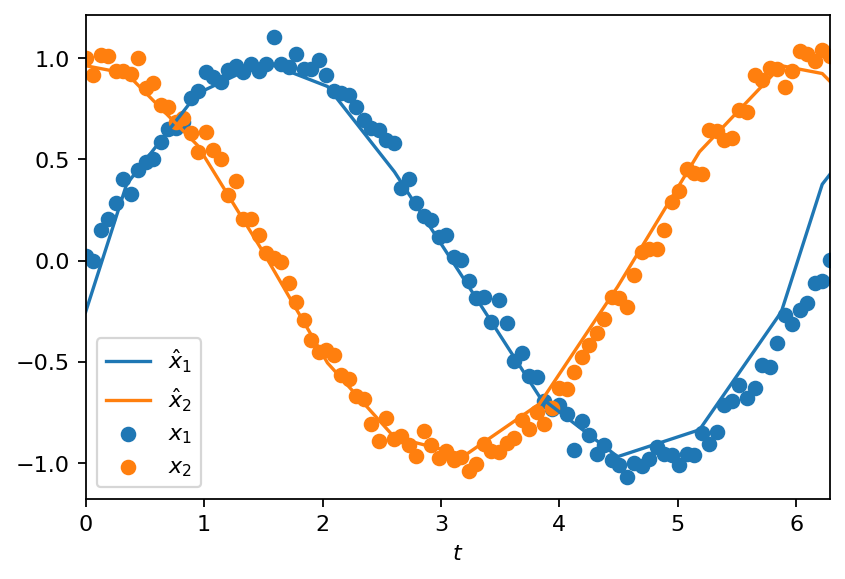

In [ ]:
plt.plot(times, prediction[:, 0], label=r"$\hat{x}_1$")
plt.plot(times, prediction[:, 1], label=r"$\hat{x}_2$")
plt.scatter(t, data[:, 0], label=r"$x_1$")
plt.scatter(t, data[:, 1], label=r"$x_2$")
plt.xlabel(r"$t$")
plt.legend()
plt.xlim(0.0, 2*np.pi)
plt.savefig(f"{output}/periodic_dataset_simulated.svg", bbox_inches="tight")

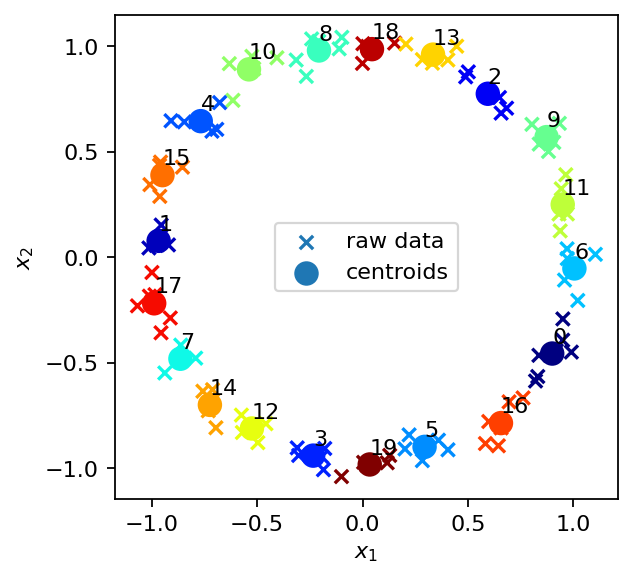

In [ ]:
clustering = KMeans(n_clusters=20, random_state=0)
clustering.fit(data.numpy())
cluster_ids = clustering.predict(data.numpy())
centroids = clustering.cluster_centers_

plt.scatter(data[:, 0], data[:, 1], c=cluster_ids, marker="x", cmap="jet", label="raw data")
plt.scatter(centroids[:, 0], centroids[:, 1], c=range(20), marker="o", s=100, cmap="jet", label="centroids")
for i, c in enumerate(centroids):
    plt.text(c[0], c[1]+0.05, f"{i}")
plt.gca().set_aspect("equal")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.savefig(f"{output}/periodic_dataset_clustering_refined.svg", bbox_inches="tight")

In [ ]:
transition_times = compute_transition_time(cluster_ids, 2.0*np.pi/100)
transition_times

{'18,13': 0.25132741228718347,
 '13,2': 0.3455751918948773,
 '2,9': 0.3455751918948773,
 '9,11': 0.3141592653589793,
 '11,6': 0.3141592653589793,
 '6,0': 0.3769911184307752,
 '0,16': 0.4084070449666731,
 '16,5': 0.3455751918948773,
 '5,19': 0.3141592653589793,
 '19,3': 0.3141592653589793,
 '3,12': 0.2827433388230814,
 '12,14': 0.25132741228718347,
 '14,7': 0.21991148575128555,
 '7,17': 0.2827433388230814,
 '17,1': 0.3141592653589793,
 '1,15': 0.2827433388230814,
 '15,4': 0.2827433388230814,
 '4,10': 0.15707963267948966,
 '10,4': 0.06283185307179587,
 '10,8': 0.3141592653589793,
 '8,18': 0.21991148575128555}

In [ ]:
def compute_transition_probabilities(centroid_sequence: np.ndarray,
                                   verbose: bool=False) -> Dict[str, np.ndarray]:
    """Compute transition probability between pairs of clusters.
    """
    prob = defaultdict(list)
    for i in range(len(centroid_sequence)-1):
        prob[str(centroid_sequence[i])].append(centroid_sequence[i+1])
    if verbose:
        print("Possible next clusters: ", prob)
    for key, next_clusters in prob.items():
        unique, counts = np.unique(next_clusters, return_counts=True)
        prob[key] = np.stack((unique, counts/counts.sum())).T
    return prob

In [ ]:
centroid_sequence = remove_sequential_duplicates(clustering.labels_)
transition_probs = compute_transition_probabilities(centroid_sequence, verbose=True)
transition_probs

Possible next clusters:  defaultdict(<class 'list'>, {'18': [13], '13': [2], '2': [9], '9': [11], '11': [6], '6': [0], '0': [16], '16': [5], '5': [19], '19': [3], '3': [12], '12': [14], '14': [7], '7': [17], '17': [1], '1': [15], '15': [4], '4': [10, 10], '10': [4, 8], '8': [18]})


defaultdict(list,
            {'18': array([[13.,  1.]]),
             '13': array([[2., 1.]]),
             '2': array([[9., 1.]]),
             '9': array([[11.,  1.]]),
             '11': array([[6., 1.]]),
             '6': array([[0., 1.]]),
             '0': array([[16.,  1.]]),
             '16': array([[5., 1.]]),
             '5': array([[19.,  1.]]),
             '19': array([[3., 1.]]),
             '3': array([[12.,  1.]]),
             '12': array([[14.,  1.]]),
             '14': array([[7., 1.]]),
             '7': array([[17.,  1.]]),
             '17': array([[1., 1.]]),
             '1': array([[15.,  1.]]),
             '15': array([[4., 1.]]),
             '4': array([[10.,  1.]]),
             '10': array([[4. , 0.5],
                    [8. , 0.5]]),
             '8': array([[18.,  1.]])})

In [ ]:
def sample_next_cluster(current: int, transition_probs) -> int:
    """Sample the next cluster probabilisticly.
    """
    key = str(current)
    return int(np.random.choice(
        transition_probs[key][:, 0], p=transition_probs[key][:, 1])
    )

In [ ]:
for _ in range(10):
    print(sample_next_cluster(10, transition_probs))

4
4
8
4
8
4
4
4
4
4


In [ ]:
def simulate_probablisticly(centroids: np.ndarray,
                            transition_probs: Dict[str, np.ndarray],
                            transition_times: Dict[str, float],
                            start_id: int,
                            end_time: float) -> Tuple[np.ndarray, np.ndarray]:
    visited_centroids, time = [start_id], [0.0]
    while time[-1] < end_time:
        visited_centroids.append(sample_next_cluster(visited_centroids[-1], transition_probs))
        transition = "{:d},{:d}".format(*visited_centroids[-2:])
        time.append(time[-1] + transition_times[transition])
        if time[-1] > end_time:
            break
    visited = np.zeros((len(time), centroids.shape[1]))
    for i, ci in enumerate(visited_centroids):
        visited[i] = centroids[ci]
    return visited, np.array(time)

In [ ]:
prediction, times = simulate_probablisticly(centroids, transition_probs, transition_times, clustering.labels_[0], 4*np.pi)

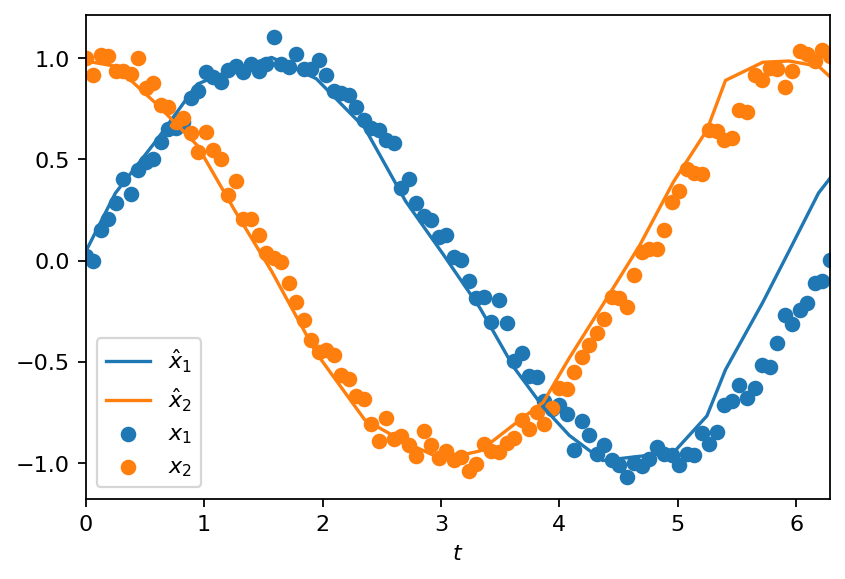

In [ ]:
plt.plot(times, prediction[:, 0], label=r"$\hat{x}_1$")
plt.plot(times, prediction[:, 1], label=r"$\hat{x}_2$")
plt.scatter(t, data[:, 0], label=r"$x_1$")
plt.scatter(t, data[:, 1], label=r"$x_2$")
plt.xlabel(r"$t$")
plt.legend()
plt.xlim(0.0, 2*np.pi)
plt.savefig(f"{output}/periodic_dataset_simulated_refined.svg", bbox_inches="tight")

In [ ]:
DATASETS=flowtorch.constants.find_datasets("/opt/ParaView-5.9.1-MPI-Linux-Python3.8-64bit/datasets/")
path = DATASETS["of_cylinder2D_binary"]
loader = FOAMDataloader(path)
times = loader.write_times
window_times = [time for time in times if float(time) >= 4.0]

# load vertices, discard z-coordinate, and create a mask
vertices = loader.vertices[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

# assemble data matrix
data_matrix = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float32)
for i, time in enumerate(window_times):
    # load the vorticity vector field, take the z-component [:, 2], and apply the mask
    data_matrix[:, i] = pt.masked_select(loader.load_snapshot("vorticity", time)[:, 2], mask)

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


In [ ]:
def encode(data_matrix: pt.Tensor, rank: int) -> Tuple[pt.Tensor, pt.Tensor]:
    U, s, VH = pt.linalg.svd(data_matrix, full_matrices=False)
    return U[:, :rank], pt.diag(s[:rank]) @ VH[:rank, :]

In [ ]:
modes, coeff = encode(data_matrix, rank=20)
print("Mode matrix shape: ", modes.shape)
print("Coeff. matrix shape: ", coeff.shape)

Mode matrix shape:  torch.Size([7190, 20])
Coeff. matrix shape:  torch.Size([20, 241])


In [ ]:
clustering = KMeans(n_clusters=40, random_state=0)
clustering.fit(coeff.T.numpy())
centroids = clustering.cluster_centers_
# transition times
times_num = np.array([float(t) for t in window_times])
dt = times_num[1] - times_num[0]
transition_times = compute_transition_time(clustering.labels_, dt)
# transition probabilities
centroid_sequence = remove_sequential_duplicates(clustering.labels_)
transition_probs = compute_transition_probabilities(centroid_sequence)

In [ ]:
prediction, times_sim = simulate_probablisticly(centroids, transition_probs, transition_times, clustering.labels_[0], 10)

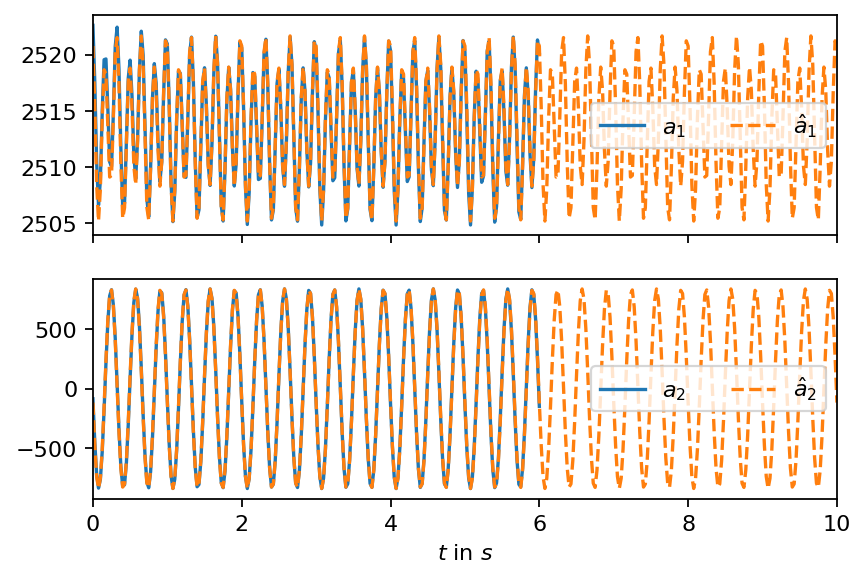

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(times_num-times_num[0], coeff[0, :], label=r"$a_1$")
ax2.plot(times_num-times_num[0], coeff[1, :], label=r"$a_2$")
ax1.plot(times_sim, prediction[:, 0], ls="--", label=r"$\hat{a}_1$")
ax2.plot(times_sim, prediction[:, 1], ls="--", label=r"$\hat{a}_2$")
ax2.set_xlabel(r"$t$ in $s$")
ax2.set_xlim(0, 10)
ax1.legend(ncol=2)
ax2.legend(ncol=2)
plt.savefig(f"{output}/cylinder_coeff_prediction_cnm.svg", bbox_inches="tight")

In [ ]:
def decode(modes: pt.Tensor, coeff: pt.Tensor) -> pt.Tensor:
    return modes @ coeff

In [ ]:
reconstruction = decode(modes, pt.from_numpy(prediction).T.type(pt.float32))

In [ ]:
def add_mode(ax, mode, title, every=4):
    ax.tricontourf(x[::every], y[::every], mode[::every], levels=15, cmap="jet")
    ax.tricontour(x[::every], y[::every], mode[::every], levels=15, linewidths=0.1, colors='k')
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_title(title)

x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)

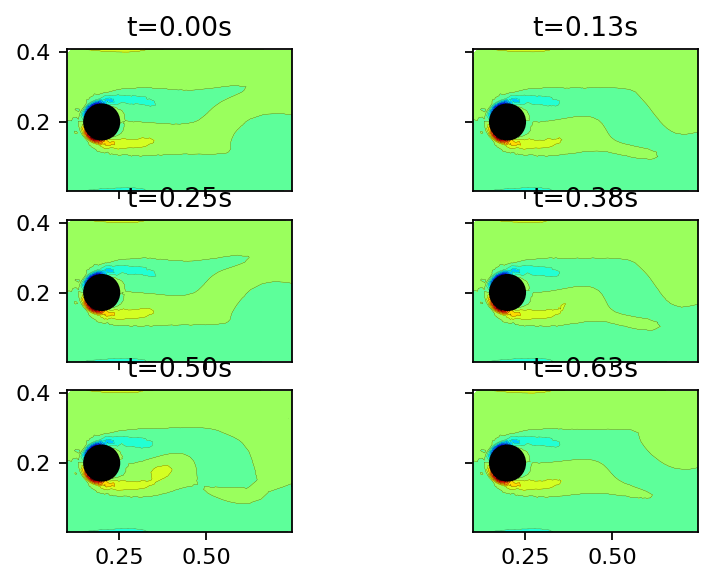

In [ ]:
fig, axarr = plt.subplots(3, 2, figsize=(6, 4), sharex=True, sharey=True)
count = 0
for row in range(3):
    add_mode(axarr[row, 0], reconstruction[:, count], f"t={times_sim[count]:2.2f}s")
    count += 5
    add_mode(axarr[row, 1], reconstruction[:, count], f"t={times_sim[count]:2.2f}s")
    count += 5
plt.savefig(f"{output}/cylinder_full_prediction_cnm.svg", bbox_inches="tight")